In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# In[2]:


# with open('weights.data', 'rb') as filehandle:
#     Weights = pickle.load(filehandle)


# In[4]:


class pixel_estimator_with_weights(nn.Module):
    def __init__(self, Weights,device = "cuda:0"):
        ## Default: gpu mode
        super(pixel_estimator_with_weights, self).__init__()
        self.device = torch.device(device)
        self.w1 = torch.from_numpy(Weights[0].transpose(3,2,0,1)).to(self.device)
        self.b1 = torch.from_numpy(Weights[1]).to(self.device)
        self.w2 = torch.tensor(Weights[2].transpose(3,2,0,1)).to(self.device)
        self.b2 = torch.tensor(Weights[3]).to(self.device)
        self.w3 = torch.tensor(Weights[4].transpose(3,2,0,1)).to(self.device)
        self.b3 = torch.tensor(Weights[5]).to(self.device)
        self.w4 = torch.tensor(Weights[6]).reshape(4,4,8,1024).permute(3,2,0,1).to(self.device)
        self.b4 = torch.tensor(Weights[7]).to(self.device)
        self.w5 = torch.tensor(Weights[8]).reshape(1,1,1024,512).permute(3,2,0,1).to(self.device)
        self.b5 = torch.tensor(Weights[9]).to(self.device)
        self.w6 = torch.tensor(Weights[10]).reshape(1,1,512,10).permute(3,2,0,1).to(self.device)
        self.b6 = torch.tensor(Weights[11]).to(self.device)
        self.w7 = torch.tensor(Weights[12]).reshape(1,1,10,1).permute(3,2,0,1).to(self.device)
        self.b7 = torch.tensor(Weights[13]).to(self.device)

    def forward(self, x):
        x = F.relu(F.conv2d(x,self.w1,bias = self.b1,stride=1))
        x = F.relu(F.conv2d(x,self.w2,bias = self.b2,stride=1,dilation=8))
        x = F.relu(F.conv2d(x,self.w3,bias = self.b3,stride=1,dilation=32))
        x = F.leaky_relu(F.conv2d(x,self.w4,bias = self.b4,stride=1,dilation=128),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w5,bias = self.b5,stride=1),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w6,bias = self.b6,stride=1),0.1)
        x = F.conv2d(x,self.w7,bias = self.b7,stride=1)
        return x

In [3]:
# import tensorflow
# from tensorflow.keras import backend as K
# from tensorflow.python.keras.models import load_model
# dist_est_net = load_model('050-0.65.hdf5')
# # func = K.function(keras_model.layers[0].input,keras_model.layers[0].output)
# # a = func(DATA)

In [4]:
# Weights = dist_est_net.get_weights()

In [5]:
# model = pixel_estimator_with_weights(Weights)

In [6]:
# torch.save(model, 'autofocus_cpu.pth')

In [7]:
model = torch.load('autofocus.pth')
model.eval()

pixel_estimator_with_weights()

In [8]:
# a = torch.ones(1, 1, 1023, 1023).to('cuda:0')
# with torch.no_grad():
#     b = model(a)
# print(b.size())

In [9]:
def crop_patches(img, window= 1023, step = 512):
    patches = []
    H, W = img.shape
    for i in range(0, H-step, step):
        for j in range(0, W-step, step):
            patches.append(img[i:i+window, j:j+window])
    return np.stack(patches)

def dis_map(img, curr = 1000, last_dist_map = None, last_move_steps = None):
    img = np.pad(img, ((200, 200), (128, 128)), 'reflect')
    H, W = img.shape

    patches = crop_patches(img)
    patches = torch.from_numpy(patches).float().unsqueeze(1).cuda()

    results = []
    with torch.no_grad():
        for i in range(patches.size()[0]):
            results.append(model(patches[i:i+1]))
    results = torch.stack(results)

    results = results.cpu().numpy()
    results = results.squeeze()

    k = 0
    n_img = np.zeros((H-512, W-512))
    for i in range(0, H-512, 512):
        for j in range(0, W-512, 512):
            n_img[i:i+512, j:j+512] = results[k]
            k += 1
    plt.imshow(n_img)
    plt.colorbar()
    plt.show()

    plt.imshow(np.abs(n_img) > 1.5)
    plt.show()
    
    if last_move_steps is not None:
        ## Focus direction: simple check
        mapa = n_img - last_move_steps
        mapb = -n_img - last_move_steps
        diffa = np.abs(mapa) - last_dist_map
        diffb = np.abs(mapb) - last_dist_map
        mask = (np.abs(diffa) < np.abs(diffb)).astype(np.float64)
        n_img = (n_img * mask + (1-mask) * (-n_img))

    curr_pos = np.ones(n_img.shape)*curr
    a1 = 0.04655
    a2 = -1.9481e-5
    b = 2*a2*curr_pos+a1
    d2 = (b)**2 - 4*a2*n_img
    sol2 = (-b + d2**0.5)/(2*a2)
    plt.imshow(sol2)
    plt.colorbar()
    plt.show()
    plt.hist(sol2.flatten(), bins = 10)
    plt.show()
    
    return n_img

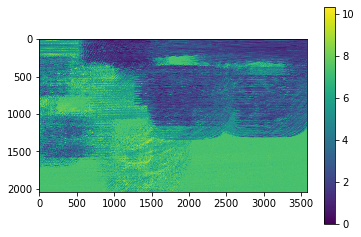

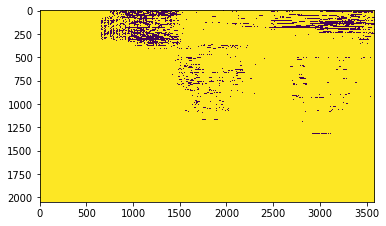

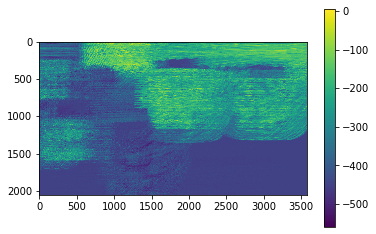

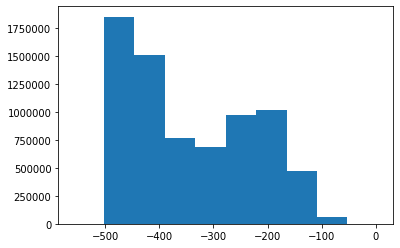

In [10]:
img = cv2.imread('9014_00.jpg', 0)/255.
n_img = dis_map(img)

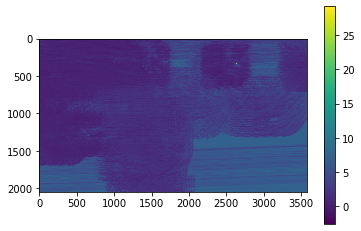

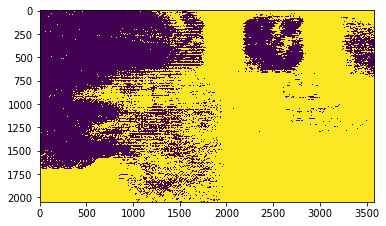

/home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in sqrt


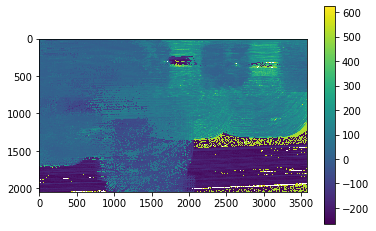

/home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


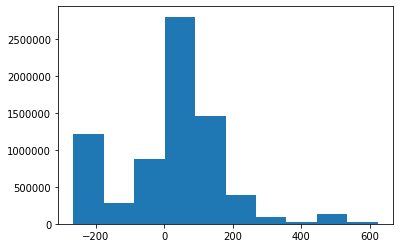

In [11]:
img = cv2.imread('9014_01.jpg', 0)/255.
n_img = dis_map(img, 571, n_img, -6.829667508602142)

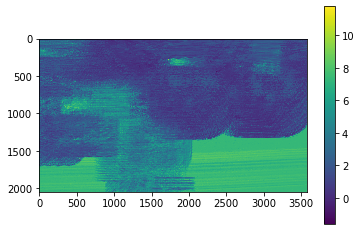

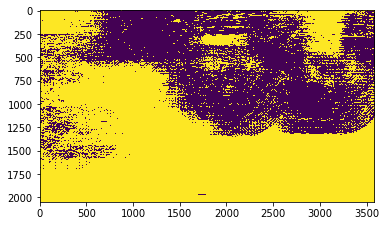

/home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in sqrt


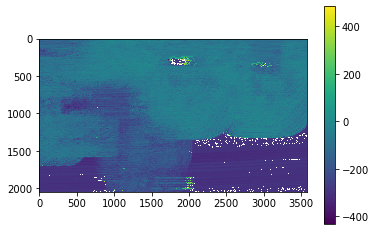

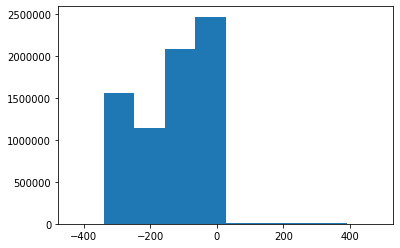

In [12]:
img = cv2.imread('9014_02.jpg', 0)/255.
n_img = dis_map(img, 710, n_img, 2.995347547531128)

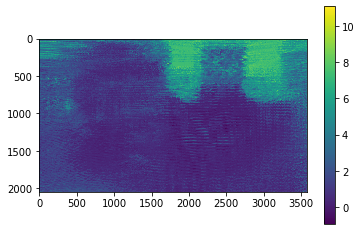

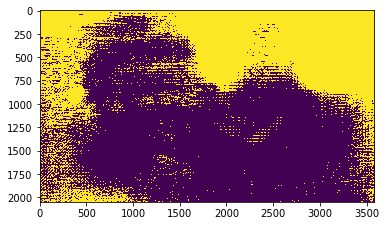

/home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in sqrt


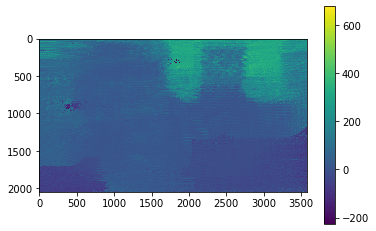

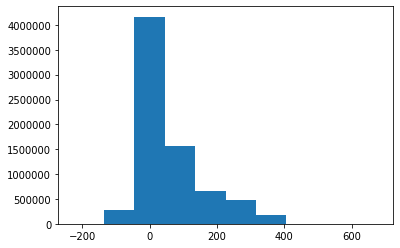

In [13]:
img = cv2.imread('9014_03.jpg', 0)/255.
n_img = dis_map(img, 450, n_img, -6.416484355926514)

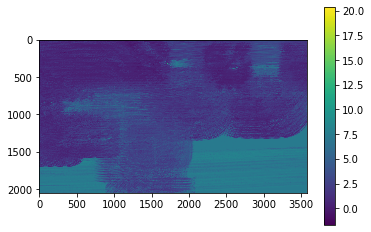

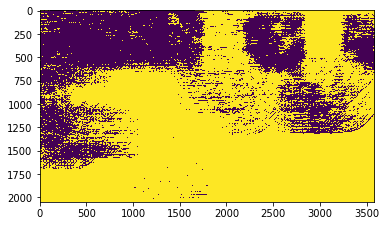

/home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in sqrt


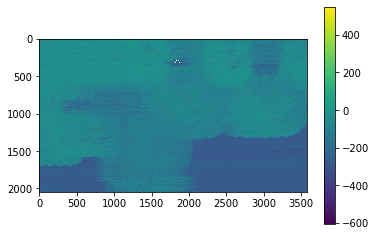

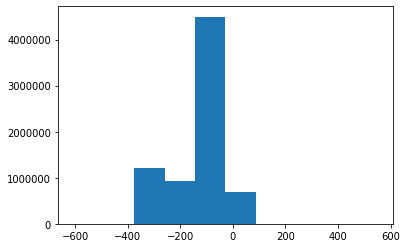

In [14]:
img = cv2.imread('9014_04.jpg', 0)/255.
n_img = dis_map(img, 638, n_img, 4.771561646461487)